In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

def path_link(path:str):
    sys.path.append(path)

path_link('/home/jpierre/v2/lib')

from norm import normalizeGraph
from torch_geometric.data import Data
from torch_geometric.utils import degree as deg
from tqdm import tqdm



import wandb


/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


NB_ROLL = 80
START_ID = 8


class Param_eval():
    def __init__(self, path = None, wandbName = None):
        self.path = path
        self.wandbName = wandbName


    def save(self):
        if self.path:
            plt.savefig(self.path)
            plt.close()

        else:
            #wandb.log({f"{self.wandbName}": wandb.Image(plt)})
            plt.close()

class EvaluationCfg():
    def __init__(self):

        self.jacobian = None

        self.normError = None
        self.angleErorr = None

        # delete + update
        if self.normError or self.angleErorr:
            self.norm_angleError = True
        else:
            self.norm_angleError = None

        self.heatmap = None

        self.L1_vect = None

        self.MSE_rollout = None

        self.degree_error = None

        self.dist_error = None

        self.MSD = None

        self.Intermediate = None

        self.jsonInfo = None
        



def evaluateLoad(loader, model, cfg: EvaluationCfg, device = DEVICE):
    """ 
    Function to comlpute the different statistics

    Args:
    -----
        - ``
        - ``
        - ``
        - ``
    """

    evalLoss = 0
    nbCall = len(loader)

    res = {}

    distList = []           # list of distances
    errorList = []          # list of errors
    degreeList = []         # list of degrees
    normError = []          # list of norm errors
    angleError = []         # list of angles errors
    messages = None
    with torch.no_grad():
        for d, _ in tqdm(loader, leave = False):
            model = model.to(DEVICE)
            d = d.to(device)
            d.x = d.x[:, 2:]
            d = normalizeGraph(d)
            pred = model(d).cpu()

            d = d.cpu()
            d.y = torch.swapaxes(d.y, 0, 1)
            model = model.cpu()

            evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))

            errors = torch.mean(torch.abs(pred - d.y[0, :, :]),dim = -1).numpy()

            if cfg.jacobian:
                pass


            if cfg.degree_error:
                degs = deg(d.edge_index[0, :], num_nodes=d.x.size(0))
                errorList.extend(errors.tolist())
                degreeList.extend(degs.numpy().tolist())


            if cfg.dist_error:
                dist = d.edge_attr[:, 0]
                #distList.extend(dist.numpy().tolist()) 
                if not cfg.degree_error:
                    errorList.extend(errors.tolist())

            #if cfg.normError or cfg.angleErorr:
            if cfg.norm_angleError:

                errorAngle, errorNorm = errorsDiv(pred.numpy(), d.y[0, :, :].numpy())
                normError.extend(errorNorm.tolist())
                angleError.extend(errorAngle.tolist())


            if cfg.L1_vect:
                m = getStdMessage(model, d.edge_attr)
                if messages is None:
                    messages = m
                else:
                    messages = np.vstack((messages, m))


        # saving results

        evalLoss = evalLoss / nbCall

        if cfg.dist_error:
            distList = np.array(distList)
            res['distList'] = distList

        if cfg.dist_error or cfg.degree_error:
            errorList = np.array(errorList)
            res['errorList'] = errorList

        if cfg.degree_error:
            degreeList = np.array(degreeList)
            res['degreeList'] = degreeList

        
        if cfg.angleErorr:
            angleError = np.array(angleError)
            res['angleError'] = angleError * 180 / np.pi

        if cfg.normError:
            normError = np.array(normError)
            res['normError'] = normError
        
        """
        if cfg.norm_angleError:
            normError = np.array(normError)
            angleError = np.array(angleError)
            res['angleError'] = angleError * 180 / np.pi
            res['normError'] = normError
        """
            

        if cfg.L1_vect:
            res['message'] = messages


        res['evalLoss'] = evalLoss
        #wandb.log({'eval loss': evalLoss})

    return res


def saveLoader(d, cfg: EvaluationCfg):
    """ 
    Function to obtain the satistics 
    """

    if cfg.L1_vect:
        plotStdMessage(d['message'])
        cfg.L1_vect.save()


    if cfg.normError:
        saveNorm(d['normError'], cfg.normError)

    if cfg.angleErorr:
        saveAngle(d['angleError'], cfg.angleErorr)

    #if cfg.norm_angleError:
    #    saveWbAnglesNorm(d['angleError'], d['normError'])

    if cfg.dist_error:
        #plotDistLoss(d['distList'], d['errorList'])
        #cfg.dist_error.save()
        pass

    if cfg.degree_error:
        plotDegreeLoss(d['degreeList'], d['errorList'])
        cfg.degree_error.save()

    if cfg.jsonInfo: 
        pass
        ## save infos in the json file




###################################################################


def evaluateSim(loader, cfg, device = DEVICE):
    
    res = {}
    data_x = None
    data_y = None

    nbRoll = NB_ROLL
    nbCalls = len(loader)

    evalLossSim = 0
    mse = 0

    for d, _ in loader:
                    
        d = torch.squeeze(d, dim = 0).numpy()
        start = START_ID       # not 0
        #res = getSimulationData(model, nbRoll, d, i = start)

        if data_x is None:
            data_x = res.numpy()
        else:
            data_x = np.concatenate((data_x, res.numpy()), axis = 0)

        if data_y is None:
            data_y = d
        else:
            data_y = np.concatenate((data_y, d), axis = 0)


        L = res.shape[0]
                        
        evalLossSim += torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start:(start + L), :, :].copy()).reshape(-1).to(device))

        if cfg.MSE_rollout:
            mse += MSE_rollout(res.copy(), d)

    res['evalLossSim'] = evalLossSim / nbCalls

    if cfg.MSE_rollout:
        res['mse_rollout'] = mse / nbCalls


    return res


################################################

def compareModels(modelList, cfg):
    pass

################################################
# one-step stats / measure
################################################

    
def compute_jacobian(model, inputs) -> torch.Tensor:
    """
    Compute the jacobian matrix with respect to the inputs
    
    Args:
    -----
        - `model` (torch.nn.Module): The neural network model.
        - `inputs` (torch.Tensor): The inputs to the neural network.
    
    Returns:
    --------
        tuple of the jacobians
    """
    model.eval()
    inputs.requires_grad_(True)
    
    outputs = model(inputs)
    jacobian1 = torch.zeros_like(inputs)
    jacobian2 = torch.zeros_like(inputs)


    for i in range(outputs.shape[0]):
        model.zero_grad()
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[i, 0] = 1  
        outputs.backward(gradient=grad_outputs, retain_graph=True)
        jacobian1[i] = inputs.grad.detach().clone()
        inputs.grad.zero_()



    for i in range(outputs.shape[0]):
        model.zero_grad()
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[i, 1] = 1  # Set up for the second output dimension
        outputs.backward(gradient=grad_outputs, retain_graph=True)
        jacobian2[i] = inputs.grad.detach().clone()
        inputs.grad.zero_()
    
    
    # Return the Jacobian matrix
    return jacobian1, jacobian2




def compute_graph_jacobian(model, inputs) -> torch.Tensor:
    """
    Compute the jacobian matrix with respect to the inputs
    
    Args:
    -----
        - `model` (torch.nn.Module): The neural network model.
        - `inputs` (torch.Tensor): The inputs to the neural network.
    
    Returns:
    --------
        tuple of the jacobians
    """
    model.eval()

    # x
    inputs.x.requires_grad_(True)
    inputs.edge_attr.requires_grad_(True)
    
    outputs = model(inputs)
    jacobian1 = torch.zeros_like(inputs.x)
    jacobian2 = torch.zeros_like(inputs.x)

    jacobian1edge = torch.zeros_like(inputs.edge_attr)
    jacobian2edge = torch.zeros_like(inputs.edge_attr)


    for i in range(outputs.shape[0]):
        model.zero_grad()
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[i, 0] = 1  
        outputs.backward(gradient=grad_outputs, retain_graph=True)
        jacobian1[i] = inputs.x.grad.detach().clone()
        jacobian1edge[i] = inputs.edge_attr.grad.detach().clone()
        inputs.x.grad.zero_()



    for i in range(outputs.shape[0]):
        model.zero_grad()
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[i, 1] = 1  # Set up for the second output dimension
        outputs.backward(gradient=grad_outputs, retain_graph=True)
        jacobian2[i] = inputs.grad.detach().clone()
        jacobian2edge[i] = inputs.edge_attr.grad.detach().clone()
        inputs.grad.zero_()
    
    
    # Return the Jacobian matrix
    return jacobian1, jacobian2, jacobian1edge, jacobian2edge



def meanJacobian(model, input):
    j1, j2, jedge1, jedge2 = compute_graph_jacobian(model, input)

    j1 = j1.cpu().numpy()
    j2 = j2.cpu().numpy()
    jedge1 = jedge1.cpu().numpy()
    jedge2 = jedge2.cpu().numpy()


    return np.mean(j1, axis = 0), np.mean(j2, axis = 0), np.mean(jedge1, axis = 0), np.mean(jedge2, axis = 0)


################################################


def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm


def saveWbAnglesNorm(errorAngle, errorNorm):

    #wandb.log({'Median Angle Error':np.median(errorAngle) })
    #wandb.log({'Median Norm Error': np.median(errorNorm) })

    return None


def saveNorm(errorNorm, norm_cfg):
    if norm_cfg.path is None:
        wandb.log({'Median Norm Error': np.median(errorNorm) })

    else:
        plt.hist(errorNorm, density=True, bins = 'auto')
        plt.xlabel('Norm error')
        plt.ylabel('Density')
        plt.savefig(norm_cfg.path)
        plt.close()


def saveAngle(errorAngle, angle_cfg):
    if angle_cfg.path is None:
        wandb.log({'Median Angle Error':np.median(errorAngle) })

    else:
        plt.hist(errorAngle, density=True, bins = 'auto')
        plt.xlabel('Norm error')
        plt.ylabel('Density')
        plt.savefig(angle_cfg.path)
        plt.close()



################################################


def getStdMessage(model, attr):
    model.eval()
    with torch.no_grad():
        v = model.GNN.message(None, None, attr).cpu().detach().numpy()
    return v



def plotStdMessage(messages):

    std = np.std(messages, axis = 0)

    plt.plot(std)
    plt.xlabel('features')
    plt.ylabel('Standard Deviation')

    return std


################################################


def plotDegreeLoss(degreeList, errorList):
    maxBin = min(np.max(degreeList), 8)
    bins = np.arange(maxBin+2) - 0.5

    plotBoxPlot(degreeList, errorList, bins, xlabel = 'Degree', ylabel = 'L1 Error')

    return None



################################################


def plotDistLoss(distList, errorList):
    bins = np.linspace(0, 6, 20)

    plotBoxPlot(distList, errorList, bins, xlabel = 'Distance', ylabel = 'L1 Error')

    return None




################################################
# simulation stats / measure
################################################


def MSE_rollout(roll, sim, display:bool = False):
    x = np.arange(roll.shape[0])
    vals = ((roll - sim) ** 2).reshape(x.shape[0], -1)
    y = np.mean(vals, axis=1)
    std = np.std(vals, axis=1)

    if display:
        plt.plot(x, y, 'blue')
        plt.fill_between(x, y-std, y+std, zorder=  2)
        plt.xlabel('Time')
        plt.ylabel('Rollout MSE')
        plt.grid(zorder = 1)

    return x, y


def applyMSE_rollout(simList, predList, color = 'blue', display:bool = False):

    res = np.zeros((len(simList), simList[0].shape[0]))

    for i in range(len(simList)):
        res[i] = MSE_rollout(predList[i], simList[i])

    res = np.mean(res, axis = 0)

    x = np.arange(res.shape[0])
    if display:
        plt.plot(x, res, 'blue')
        #plt.fill_between(x, y-std, y+std, zorder=  2)
        plt.xlabel('Time')
        plt.ylabel('Rollout MSE')
        plt.grid(zorder = 1)


################################################


def MSD_comp(traj, tau):
    T = traj.shape[0]
    i = np.arange(T - tau)
    j = i + tau

    return np.linalg.norm(traj[j, :, :] - traj[i, :, :], axis=-1)**2

def MSD(traj: np.array)-> np.array:
    """
    Allows to compute the Mean Squared Displacement of the trajectories for all timestamps
    
    Args:
    -----
    - `traj`: np.array of N trajectories of length T [NxT]
    
    Output:
    -------
    Mean Squared Displacement for all timestamps
    """

    res = []
    T = traj.shape[0]
    
    for tau in range(1, T):
        val = np.mean(np.mean(MSD_comp(traj, tau), axis=0), axis=0)
        res.append(val)

    return res

def applyMSD(sims:list, dislpay:bool = False, color:str = 'blue')->np.array:
    """ 
    Function to apply MSD to a group of simulations

    NOTE: test

    Args:
    -----
        - `sims` (list): list of simualtions

    Returns:
    --------
        np array [#Sim, T-1] of MSD computations
    """

    res = np.zeros((len(sims), sims[0].shape[0]-1))
    for i in range(len(sims)):
        sim = sims[i]
        res[i, :] = np.array(MSD(sim))


    if dislpay:
        x = np.arange(sims[0].shape[0]-1)
        y = np.mean(res, axis = 0)
        std = np.std(res, axis = 0)
        plt.plot(x, y, color = color, zorder = 1)
        #plt.fill_between(x, y - std, y+std, color = 'red', alpha = 0.4, zorder = 2)
        
        plt.xlabel('Time')
        plt.ylabel('MSD')

    return res


################################################

def SelfIntermediateA(data, qval, verbose=False):
    T, N, _ = data.shape  # T is the number of time steps, N is the number of particles
    qval = np.array(qval, dtype=np.complex128)  # Ensure wave vector is complex for the computation
    
    SelfInt = np.empty((T-1,), dtype=np.complex128)
    
    for t in range(T-1):
        smax = T - t  
        
        rt = data[:smax]       
        rtplus = data[t:] 
        dr = rt - rtplus
        
        exp_factor = np.exp(1j * (qval[0] * dr[:, :, 0] + qval[1] * dr[:, :, 1]))
        
        SelfInt[t] = np.sum(exp_factor) / (N * smax)
    
    SelfInt_mod = np.sqrt(np.real(SelfInt)**2 + np.imag(SelfInt)**2)
    
    tval = np.linspace(0, T-1, num=T-1)
    
    if verbose:
        plt.figure(figsize=(10, 5))
        plt.semilogy(tval, SelfInt_mod, '.-r', lw=2)
        plt.xlabel('time')
        plt.ylabel('F_s(k,t)')
        plt.title('Self-intermediate Function')
        plt.grid(True)
        plt.ylim([0, 1])
        plt.show()
    
    return tval, SelfInt_mod, SelfInt


def applySelfScattering(simList, qval = None, display:bool = False, color = 'blue'):
    if qval is None:
        R = 1       #ngfjdngjdnsjhnjfnvjfdnbjvnfdjkgnfjkdhvbjkdhgjklhgjkd
        qval = 2*np.pi/R*np.array([1,0])

    res = np.zeros((len(simList),simList[0].shape[0]-1 ))

    for i in range(len(simList)):
        sim = simList[i]

        val = SelfIntermediateA(sim.copy(), qval.copy(), verbose = False)[1]
        res[i] = val

    r = np.mean(res, axis=0)
    delta = np.std(r, axis = 0)

    if display:
        plt.figure(figsize=(10, 5))
        t = np.arange(1, simList[0].shape[0])

        plt.grid()
        plt.semilogy(t, r, color = color, lw=2)
       # plt.fill_between(t, r-delta, r+delta, color = color, alpha = 0.4)
        plt.xlabel('time')
        plt.ylabel('F_s(k,t)')
        plt.title('Self-intermediate Function')
        plt.grid(True)
        plt.ylim([0, 1])



################################################


def compareModels(simulationsList, paths, labels, colors):

    for modId in simulationsList.shape[0]:

        if modId > 0:
            # rollout MSE
            applyMSE_rollout(simulationsList[modId], simulationsList[0], display=True, color=colors[modId])

        
    plt.show()


    for modId in simulationsList.shape[0]:

        applyMSD(simulationsList[modId], dislpay=True, color=colors[modId])

        
    plt.show()


    for modId in simulationsList.shape[0]:

        applySelfScattering(simulationsList[modId], color=colors[modId], display=True)

        
    plt.show()


################################################
# one-step simulation stats / measure
################################################

def heatmap(values, positions, grid_size=(50, 50), plot_size=(8, 6), mode = 'max', display = True):
    """
    Visualizes the mean acceleration at different positions in a heatmap manner.

    Parameters:
    - values: np.array of shape [T, N, 2], representing the acceleration vectors of N cells over T timesteps.
    - positions: np.array of shape [T, N, 2], representing the spatial positions of N cells over T timesteps.
    - grid_size: Tuple representing the dimensions of the grid used to calculate mean values.
    - plot_size: Tuple representing the size of the output plot.
    """
    
    # Flatten the position and acceleration_norms arrays
    flattened_positions = positions.reshape(-1, 2)
    flattened_values = values.flatten()

    # Create a grid
    x_positions, y_positions = flattened_positions[:, 0], flattened_positions[:, 1]
    x_edges = np.linspace(x_positions.min(), x_positions.max(), grid_size[0] + 1)
    y_edges = np.linspace(y_positions.min(), y_positions.max(), grid_size[1] + 1)

    # Digitize the positions to find out which grid cell each belongs to
    x_inds = np.digitize(x_positions, x_edges) - 1
    y_inds = np.digitize(y_positions, y_edges) - 1

    # Accumulate the acceleration norms in their respective grid cells and count the entries
    accumulation_grid = np.zeros(grid_size, dtype=np.float64)
    count_grid = np.zeros(grid_size, dtype=np.int32)

    for x_ind, y_ind, v in zip(x_inds, y_inds, flattened_values):
        if 0 <= x_ind < grid_size[0] and 0 <= y_ind < grid_size[1]:
            if mode == 'mean':
                accumulation_grid[x_ind, y_ind] += v
            elif mode == 'max':
                accumulation_grid[x_ind, y_ind] = max(accumulation_grid[x_ind, y_ind], v)
            elif mode == 'min':
                accumulation_grid[x_ind, y_ind] = min(accumulation_grid[x_ind, y_ind], v)

            count_grid[x_ind, y_ind] += 1


    if display:
        # Avoid division by zero
        if mode == 'mean':
            with np.errstate(divide='ignore', invalid='ignore'):
                mean_acceleration_grid = np.true_divide(accumulation_grid, count_grid)

        else:
            mean_acceleration_grid = accumulation_grid

        if np.any(count_grid == 0):
            mean_acceleration_grid[count_grid == 0] = np.nan  # Set cells with no data to NaN

        # Plotting the heatmap
        plt.figure(figsize=plot_size)
        plt.imshow(mean_acceleration_grid.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap='jet')
        plt.colorbar(label='Error')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Heatmap of Error')



################################################
# Additional measures
################################################


def showDegrees(data):
    
    import features as ft

    degreeList = []

    x, y, attr, inds = ft.processSimulation(data)

    for i in range(len(x)):
        s = Data(x = x[i][:, 2:], y = y[i], edge_index = inds[i], edge_attr = attr[i])

        degs = deg(s.edge_index[0, :], num_nodes=s.x.size(0))

        degreeList.extend(degs.cpu().numpy().tolist())


    degreeList = np.array(degreeList)
    plt.hist(degreeList, bins = 'auto')
    plt.xlabel('degree')
    plt.ylabel('number of instances')

    return degreeList


################################################


def showDistancess(data):
    
    import features as ft

    distList = []

    x, y, attr, inds = ft.processSimulation(data)

    for i in range(len(x)):
        s = Data(x = x[i][:, 2:], y = y[i], edge_index = inds[i], edge_attr = attr[i])

        dist = s.edge_attr[:, 0]

        distList.extend(dist.cpu().numpy().tolist())  


    degreeList = np.array(degreeList)
    plt.hist(degreeList, bins = 'auto')
    plt.xlabel('distances')
    plt.ylabel('number of instances')

    return degreeList

################################################
# supplementary functions
################################################


def plotBoxPlot(diff, vals, bins, xlabel = 'X values', ylabel = 'y values', showfliers = False, delta:int = 1):

    groups = np.digitize(diff, bins)
    grouped_errors = {i: [] for i in range(len(bins)+1)}

    for idx, group in enumerate(groups):
        grouped_errors[group].append(vals[idx])

    
    centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    minAdd = [min(centers)-delta]
    maxAdd = [max(centers) + delta]
    centers = minAdd + centers + maxAdd
    data_to_plot = [grouped_errors[k] for k in sorted(grouped_errors.keys())]
    medians = [np.median(g) if g else None for g in data_to_plot]

    boxprops = dict(linestyle='-', linewidth=2, color='black')  # Custom box properties
    medianprops = dict(linestyle='-', linewidth=0, color='orange')  # Invisible median line
    boxplot_elements = plt.boxplot(data_to_plot, positions=centers, boxprops=boxprops, medianprops=medianprops, showfliers=showfliers, widths = 0.2)

    plt.plot(centers, medians, 'o-', color='orange', label='Medians')


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return medians

In [20]:
print(sys.path)

['/home/jpierre/v2/evaluate_folder', '/home/jpierre/anaconda3/envs/myenvPy/lib/python39.zip', '/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9', '/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9/lib-dynload', '', '/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9/site-packages', '/home/jpierre/v2/lib', '/home/jpierre/v2/models', '/home/jpierre/v2/models']


### Paths

In [21]:
import os
cwd = os.getcwd()
p = os.path.join(cwd, 'ims')

In [22]:
jacobian_cfg = Param_eval(path=os.path.join(p, 'jacobian.png'))

angle_cfg = Param_eval(path=os.path.join(p, 'angle.png'))

norm_cfg = Param_eval(path=os.path.join(p, 'norm.png'))

heatmap_cfg = Param_eval(path=os.path.join(p, 'heatmaps.png'))

L1_vect_cfg = Param_eval(path=os.path.join(p, 'l1.png'))

MSE_rollout_cfg = Param_eval(path=os.path.join(p, 'mse_rollout.png'))

degree_error_cfg = Param_eval(path=os.path.join(p, 'degree.png'))

dist_error_cfg = Param_eval(path=os.path.join(p, 'dist.png'))

MSD_cfg = Param_eval(path=os.path.join(p, 'msd.png'))

Intermediate_cfg = Param_eval(path=os.path.join(p, 'scattering.png'))

In [23]:
cfg = EvaluationCfg()

cfg.jacobian = jacobian_cfg
cfg.normError = norm_cfg
cfg.angleErorr = angle_cfg
cfg.heatmap = heatmap_cfg
cfg.L1_vect = L1_vect_cfg
cfg.MSE_rollout = MSE_rollout_cfg
cfg.degree_error = degree_error_cfg
cfg.dist_error = dist_error_cfg
cfg.MSD = MSD_cfg
cfg.Intermediate = Intermediate_cfg

### Testing one-step initialized stats

In [7]:
import dataLoading as dl
from torch_geometric.loader import DataLoader

PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader


p_data = '/scratch/users/jpierre/mew_0.001_normal'
batchSizeEval = 256
p_json = '/home/jpierre/v2/path_datasets/mew_0.001_normal'
loader = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')

yessss sir


In [8]:
def loadModel(modelName:str, inputShape:int = 8, edges_shape = 5, path = None):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    model = loadFun.loadNetwork(inputShape, edges_shape)

    return model

path_link('/home/jpierre/v2/models')

model = loadModel('simplest',path = '/home/jpierre/v2/models')
std = torch.load('simplest_drop_no-enc_aug_best-Copy1.pt')
model.load_state_dict(std)
model.eval()
model = model.to(DEVICE)

>>>> loading simplest
INFO >>> with 1 L1 reg


In [9]:
print(loader)

In [10]:
d = evaluateLoad(loader, model, cfg, device = DEVICE)

In [24]:
saveLoader(d, cfg)

In [11]:
print(d['distList'])
print(len(d['distList']))

[]
0


In [12]:
print(d['errorList'])
print(len(d['errorList']))

[0.00798204 0.0068399  0.00193267 ... 0.00220713 0.0018027  0.00127071]
5934000


In [13]:
print(d['degreeList'])
print(len(d['degreeList']))

[4. 0. 1. ... 2. 1. 1.]
5934000


In [14]:
print(d['angleError'])
print(len(d['angleError']))

[1.42861603 0.0650234  4.53943935 ... 6.0001436  1.42775542 1.44925686]
5934000


In [15]:
def plotBoxPlot(diff, vals, bins, xlabel = 'X values', ylabel = 'y values', showfliers = False, delta:int = 1):

    groups = np.digitize(diff, bins)
    grouped_errors = {i: [] for i in range(len(bins)+1)}

    for idx, group in enumerate(groups):
        grouped_errors[group].append(vals[idx])

    
    centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    minAdd = [min(centers)-delta]
    maxAdd = [max(centers) + delta]
    centers = minAdd + centers + maxAdd
    data_to_plot = [grouped_errors[k] for k in sorted(grouped_errors.keys())]
    medians = [np.median(g) if g else None for g in data_to_plot]

    boxprops = dict(linestyle='-', linewidth=2, color='black')  # Custom box properties
    medianprops = dict(linestyle='-', linewidth=0, color='orange')  # Invisible median line
    boxplot_elements = plt.boxplot(data_to_plot, positions=centers, boxprops=boxprops, medianprops=medianprops, showfliers=showfliers, widths = 0.2)

    plt.plot(centers, medians, 'o-', color='orange', label='Medians')


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return medians

[None,
 0.008342631161212921,
 0.0038538994267582893,
 0.003832215443253517,
 0.003544831066392362,
 0.0030731993028894067,
 0.003177051432430744,
 0.0027989728841930628,
 0.002218190347775817,
 0.0019795120460912585,
 0.0020377807086333632]

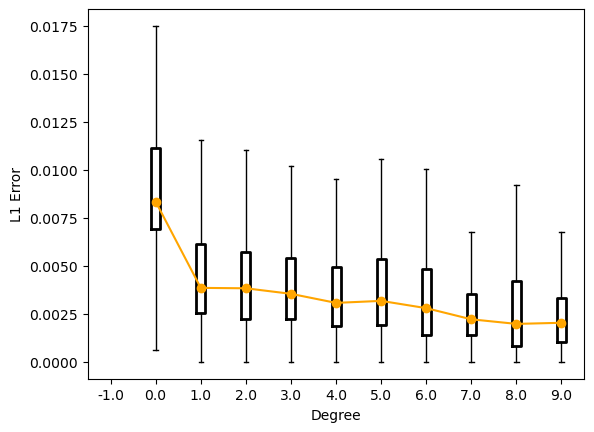

In [16]:
degreeList, errorList =  d['degreeList'], d['errorList']

maxBin = min(np.max(degreeList), 8)
bins = np.arange(maxBin+2) - 0.5

plotBoxPlot(degreeList, errorList, bins, xlabel = 'Degree', ylabel = 'L1 Error')

In [ ]:
print(maxBin)

In [177]:
print(bins)

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5]


In [127]:
print(len(bins))

10
